In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import zipfile
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
!pip install tensorflow-addons==0.16.1
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00


# Problem Description/Data

We have been given photos of landscapes, as well as corresponding Monet paintings. Our aim is to create a model that can take photos as inputs and generate Monet-style paintings. Kaggle has sophisticated means of testing how "Monet-esque" are model output is.

We'll begin by making tensorflow dataset objects out of the monet and photo tfrec directories. We will use a dataset of size 16. We are making an assumption (based on the competition description) that we are being given 300 Monet images, and 7000 photos to work with. To prepare the data, we'll create a parse function that will decode the images into numerical data (256x256x3, for RGB). The data will be ready to start using with our models.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

def _parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),       
        'image_name': tf.io.FixedLenFeature([], tf.string), 
        'target': tf.io.FixedLenFeature([], tf.string)      
    }
    parsed_example = tf.io.parse_single_example(proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.resize(image, [256, 256]) 
    image = image / 127.5 - 1
    image_name = parsed_example['image_name']
    target = parsed_example['target']  
    
    return image, image_name, target

raw_dataset = tf.data.TFRecordDataset(PHOTO_FILENAMES)
dataset_photos = raw_dataset.map(_parse_function)
dataset_photos = dataset_photos.shuffle(buffer_size=100).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
raw_monet = tf.data.TFRecordDataset(MONET_FILENAMES)
dataset_monet = raw_monet.map(_parse_function)
dataset_monet = dataset_monet.shuffle(buffer_size=100).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
print(dataset_photos.element_spec)
print(dataset_monet.element_spec)


Monet TFRecord Files: 5
Photo TFRecord Files: 20
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))


# EDA

Let's create some visualizations of our data. We can try creating a histogram of the brightness values of each image.

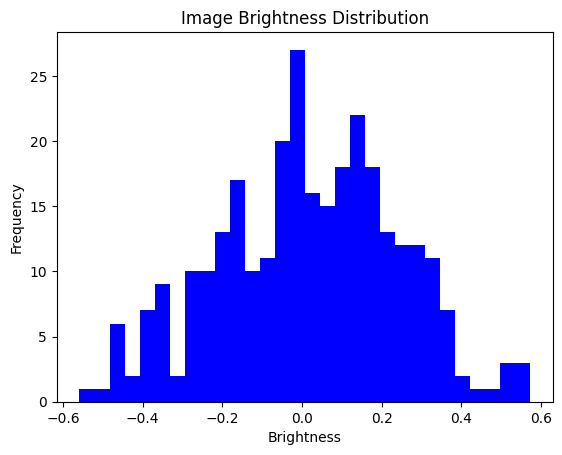

In [3]:
brightness_values = []
for batch in dataset_monet:
    images, _, _ = batch  # Unpack the batch
    for image in images:
        brightness = tf.reduce_mean(image).numpy()
        brightness_values.append(brightness)

plt.hist(brightness_values, bins=30, color="blue")
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()

Interesting - this is a sample size of 300. It's obviously not perfectly normal, but would be interesting if we had a larger Monet dataset or synthetic data - or perhaps the entire 2000+ painting collection of Monet's work.

We'll look at the brightness distribution of photos as well.

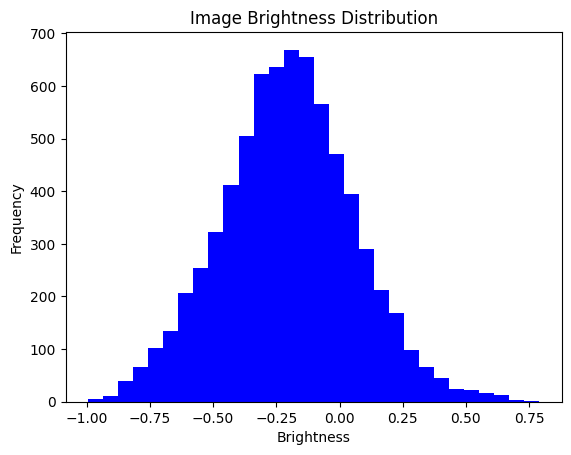

In [4]:
brightness_values = []
for batch in dataset_photos:
    images, _, _ = batch  # Unpack the batch
    for image in images:
        brightness = tf.reduce_mean(image).numpy()
        brightness_values.append(brightness)

plt.hist(brightness_values, bins=30, color="blue")
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()

Looks about normally distributed! Let's look at the color distribution for paintings and photos respectively.

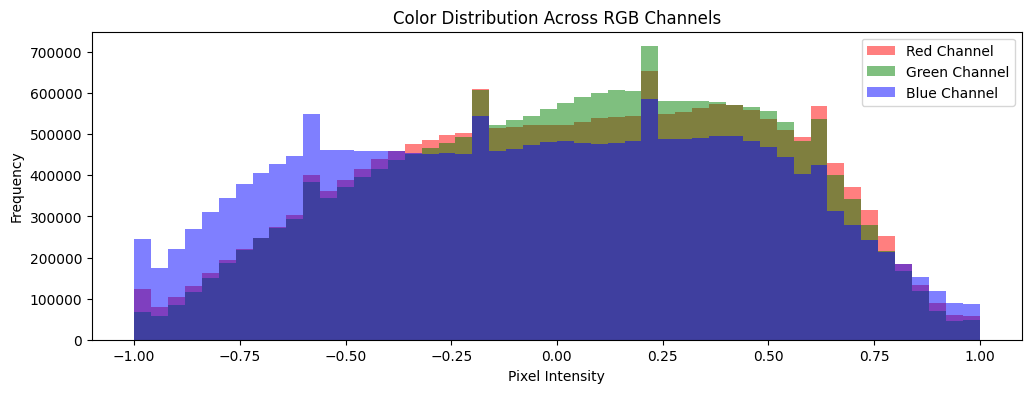

In [5]:
reds, greens, blues = [], [], []

for batch in dataset_monet:
    images, _, _ = batch  
    
    
    for image in images:
        reds.extend(image[:, :, 0].numpy().flatten())
        greens.extend(image[:, :, 1].numpy().flatten())
        blues.extend(image[:, :, 2].numpy().flatten())

plt.figure(figsize=(12, 4))

plt.hist(reds, bins=50, color='red', alpha=0.5, label="Red Channel")
plt.hist(greens, bins=50, color='green', alpha=0.5, label="Green Channel")
plt.hist(blues, bins=50, color='blue', alpha=0.5, label="Blue Channel")

plt.title("Color Distribution Across RGB Channels")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

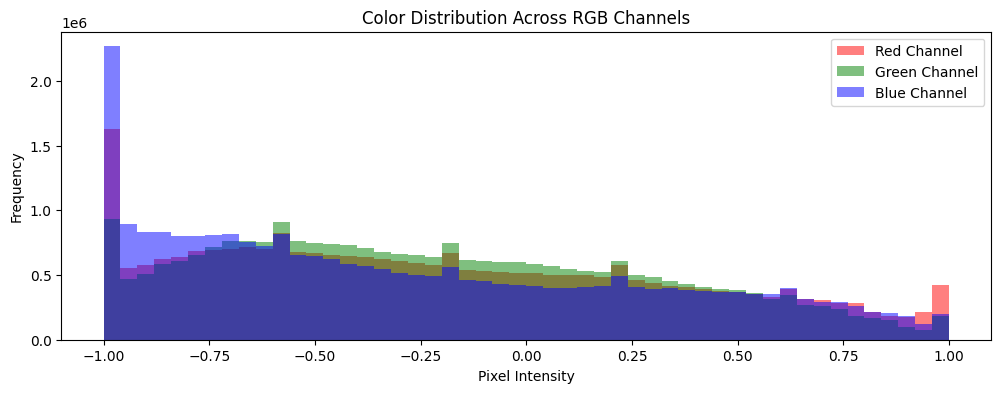

In [6]:
import random

sample_size = 25  
reds, greens, blues = [], [], []

sampled_batches = random.sample(list(dataset_photos), sample_size)

for batch in sampled_batches:
    images, _, _ = batch  
    
    for image in images:
        reds.extend(image[:, :, 0].numpy().flatten())
        greens.extend(image[:, :, 1].numpy().flatten())
        blues.extend(image[:, :, 2].numpy().flatten())

plt.figure(figsize=(12, 4))

plt.hist(reds, bins=50, color='red', alpha=0.5, label="Red Channel")
plt.hist(greens, bins=50, color='green', alpha=0.5, label="Green Channel")
plt.hist(blues, bins=50, color='blue', alpha=0.5, label="Blue Channel")

plt.title("Color Distribution Across RGB Channels")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Models

Let's review the architecture of a cycle-GAN at a high level. We have two types of models that make up our cycle-GAN, a generator, and a discriminator. The generator will generate images, given an input. The discriminator will attempt to classify images as real, or fake. We need two generators, and two discriminators for our model: one generator for Photo -> Monet painting, and one generator for Monet painting -> Photo. We need two discriminators, one to classify the results of each generator. 

Our P->M generator will take a photo as input, and generate a Monet representation of the image, and our M->P generator will take the created Monet image, and try to re-create the original photo. The inverse of this process, (M->P takes a real Monet image and generates a fake photo, P->M tries to re-create the original real Monet image), occurs also. This process of training the generators gives us cycle consistency loss. 

Each discriminator receives either a fake photo/real photo, as well as a fake painting/real painting. Through the training process, the lease squares loss is computed each epoch.

A common pitfall is for the discriminator to "learn" faster than the generator, so we will generally have the learning rate set higher for the generator, so it can stay ahead. We will experiment with hyperparameters, as well as tweaks to the training flow and architecture.

The code to create the generator and discriminator models follows. We are using a fairly standard CNN architecture for both.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.InputLayer(input_shape=(256, 256, 3)))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(3, (4, 4), padding='same', use_bias=False, activation='tanh'))

    return model









In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model(use_sigmoid=True):
    """
    Create a discriminator model for GAN.
    Args:
        use_sigmoid: Boolean to determine if final activation should be sigmoid
                    (True for standard GAN, False for WGAN)
    """
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                     input_shape=[256, 256, 3]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
       
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
       
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
       
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
     
        layers.Flatten(),
        
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        
        layers.Dense(1, activation='sigmoid' if use_sigmoid else None)
    ])
    
    return model



discriminator_monet = make_discriminator_model()  
discriminator_photo = make_discriminator_model()

generator_photo_to_monet = make_generator_model()  
generator_monet_to_photo = make_generator_model() 



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss_fn = tf.keras.losses.MeanSquaredError()

import tensorflow as tf

def discriminator_loss(real_output, fake_output):
    """
    Discriminator loss using MSE with label smoothing and noise reduction
    Args:
        real_output: Discriminator predictions on real images
        fake_output: Discriminator predictions on generated images
    """
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss * 1.1 + fake_loss * 0.9
    
    return total_loss

def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity=5):
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)






Our function train_step will train the generator and discriminator, calculate the cycle loss
and discriminator loss, and apply gradients to our training variables. Train_step is called
by train which establishes the outer loop, iterating thru the number of epochs we specify.
After the final epoch, save_paintings is called which produces our final output.

In [10]:
discriminator_monet = make_discriminator_model()  
discriminator_photo = make_discriminator_model()

generator_photo_to_monet = make_generator_model()  
generator_monet_to_photo = make_generator_model() 




import tensorflow as tf
import os
import matplotlib.pyplot as plt

generator_p2m_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
generator_m2p_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
discriminator_monet_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)

@tf.function
def train_step(real_photos, real_monets):
    with tf.GradientTape(persistent=True) as tape:
        fake_monets = generator_photo_to_monet(real_photos, training=True)
        fake_photos = generator_monet_to_photo(real_monets, training=True)

        disc_real_monet = discriminator_monet(real_monets, training=True)
        disc_fake_monet = discriminator_monet(fake_monets, training=True)
        disc_real_photo = discriminator_photo(real_photos, training=True)
        disc_fake_photo = discriminator_photo(fake_photos, training=True)

        gen_photo_to_monet_loss = generator_loss(disc_fake_monet)
        gen_monet_to_photo_loss = generator_loss(disc_fake_photo)
        
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

        cycled_photos = generator_monet_to_photo(fake_monets, training=True)
        cycled_monets = generator_photo_to_monet(fake_photos, training=True)
        
        LAMBDA_CYCLE = 10.0
        cycle_loss_total = (cycle_loss(real_photos, cycled_photos) + 
                          cycle_loss(real_monets, cycled_monets)) * LAMBDA_CYCLE

        LAMBDA_IDENTITY = 0.5 * LAMBDA_CYCLE
        same_monets = generator_photo_to_monet(real_monets, training=True)
        same_photos = generator_monet_to_photo(real_photos, training=True)
        identity_loss_total = (identity_loss(real_monets, same_monets) + 
                             identity_loss(real_photos, same_photos)) * LAMBDA_IDENTITY

        total_gen_p2m_loss = (gen_photo_to_monet_loss + 
                            cycle_loss_total * 0.5 + 
                            identity_loss_total * 0.5)
                            
        total_gen_m2p_loss = (gen_monet_to_photo_loss + 
                            cycle_loss_total * 0.5 + 
                            identity_loss_total * 0.5)

    gen_p2m_grads = tape.gradient(total_gen_p2m_loss, 
                                generator_photo_to_monet.trainable_variables)
    gen_m2p_grads = tape.gradient(total_gen_m2p_loss, 
                                generator_monet_to_photo.trainable_variables)
    disc_monet_grads = tape.gradient(disc_monet_loss, 
                                   discriminator_monet.trainable_variables)
    disc_photo_grads = tape.gradient(disc_photo_loss, 
                                   discriminator_photo.trainable_variables)

    generator_p2m_optimizer.apply_gradients(
        zip(gen_p2m_grads, generator_photo_to_monet.trainable_variables))
    generator_m2p_optimizer.apply_gradients(
        zip(gen_m2p_grads, generator_monet_to_photo.trainable_variables))
    discriminator_monet_optimizer.apply_gradients(
        zip(disc_monet_grads, discriminator_monet.trainable_variables))
    discriminator_photo_optimizer.apply_gradients(
        zip(disc_photo_grads, discriminator_photo.trainable_variables))

    return total_gen_p2m_loss + total_gen_m2p_loss, disc_monet_loss, disc_photo_loss

def train(dataset_photo, dataset_monet, epochs):
    for epoch in range(epochs):
        print(f'Starting epoch {epoch + 1}')
        
        total_gen_loss = 0
        total_disc_monet_loss = 0
        total_disc_photo_loss = 0
        n_batches = 0
        
        for photo_batch, monet_batch in tf.data.Dataset.zip((dataset_photo, dataset_monet)):
                        
            gen_loss, disc_m_loss, disc_p_loss = train_step(photo_batch[0], monet_batch[0])
            
            total_gen_loss += gen_loss
            total_disc_monet_loss += disc_m_loss
            total_disc_photo_loss += disc_p_loss
            n_batches += 1
        
        if n_batches > 0:
            print(f'Epoch {epoch + 1}:')
            print(f'Generator Loss: {total_gen_loss/n_batches}')
            print(f'Monet Discriminator Loss: {total_disc_monet_loss/n_batches}')
            print(f'Photo Discriminator Loss: {total_disc_photo_loss/n_batches}')
        
    save_paintings(generator_photo_to_monet,dataset_photo)

def save_paintings(model, dataset_photo):
    images_saved = 0
    batch_num = 0
    tmp_dir = '/tmp/images'
    os.makedirs(tmp_dir, exist_ok=True)

    for photo_batch in dataset_photo:
        
        predictions = model(photo_batch, training=False)
        for i in range(predictions.shape[0]):
            img = (predictions[i] + 1) * 127.5  
            img = tf.clip_by_value(img, 0, 255)
            img = img.numpy().astype('uint8')
            plt.imsave(f'{tmp_dir}/image_{images_saved}_{batch_num}.png', img)
            images_saved += 1
        batch_num += 1


In [11]:
import zipfile
import os

# EPOCHS = 200
# train(dataset_photos,dataset_monet,EPOCHS)
# tmp_dir = '/tmp/images'
# zip_file_path = '/kaggle/working/images.zip'
# with zipfile.ZipFile(zip_file_path, 'w') as zipf:
#     for filename in os.listdir(tmp_dir):
#         file_path = os.path.join(tmp_dir, filename)
#         zipf.write(file_path, arcname=filename)

# print(f"Images saved and zipped at {zip_file_path}")




# Results and Analysis

There are many different factors we could play with, we decided to focus on epochs and learning rate. The best-performing result was use of 200 epochs, and a learning rate of .0002 for the generator, and 0.0001 for the discriminator. This yielded a decent score for the leaderboard. With the limited computing power we have, a single test run-through takes many hours, and with this being a simple assignment to learn the basics of GANs, there is only so much we can cover. A last architectural tweak we experimented with was training the generator twice as much as the discriminator, which has been said to improve training stability. The code for this is below, and full results below the code.

We'll experiment with training the generator twice as much as the discriminator.

In [12]:
@tf.function
def train_step_double(real_photos, real_monets,generator_photo_to_monet,generator_monet_to_photo):
    with tf.GradientTape(persistent=True) as tape:
        fake_monets = generator_photo_to_monet(real_photos, training=True)
        fake_photos = generator_monet_to_photo(real_monets, training=True)

        disc_real_monet = discriminator_monet(real_monets, training=True)
        disc_fake_monet = discriminator_monet(fake_monets, training=True)
        disc_real_photo = discriminator_photo(real_photos, training=True)
        disc_fake_photo = discriminator_photo(fake_photos, training=True)

        gen_photo_to_monet_loss = generator_loss(disc_fake_monet)
        gen_monet_to_photo_loss = generator_loss(disc_fake_photo)
        
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

        cycled_photos = generator_monet_to_photo(fake_monets, training=True)
        cycled_monets = generator_photo_to_monet(fake_photos, training=True)
        
        LAMBDA_CYCLE = 10.0
        cycle_loss_total = (cycle_loss(real_photos, cycled_photos) + 
                            cycle_loss(real_monets, cycled_monets)) * LAMBDA_CYCLE

        LAMBDA_IDENTITY = 0.5 * LAMBDA_CYCLE
        same_monets = generator_photo_to_monet(real_monets, training=True)
        same_photos = generator_monet_to_photo(real_photos, training=True)
        identity_loss_total = (identity_loss(real_monets, same_monets) + 
                               identity_loss(real_photos, same_photos)) * LAMBDA_IDENTITY

        total_gen_p2m_loss = (gen_photo_to_monet_loss + 
                              cycle_loss_total * 0.5 + 
                              identity_loss_total * 0.5)
                              
        total_gen_m2p_loss = (gen_monet_to_photo_loss + 
                              cycle_loss_total * 0.5 + 
                              identity_loss_total * 0.5)

    gen_p2m_grads = tape.gradient(total_gen_p2m_loss, generator_photo_to_monet.trainable_variables)
    gen_m2p_grads = tape.gradient(total_gen_m2p_loss, generator_monet_to_photo.trainable_variables)

    generator_p2m_optimizer.apply_gradients(zip(gen_p2m_grads, generator_photo_to_monet.trainable_variables))
    generator_m2p_optimizer.apply_gradients(zip(gen_m2p_grads, generator_monet_to_photo.trainable_variables))
    generator_p2m_optimizer.apply_gradients(zip(gen_p2m_grads, generator_photo_to_monet.trainable_variables))
    generator_m2p_optimizer.apply_gradients(zip(gen_m2p_grads, generator_monet_to_photo.trainable_variables))

    disc_monet_grads = tape.gradient(disc_monet_loss, discriminator_monet.trainable_variables)
    disc_photo_grads = tape.gradient(disc_photo_loss, discriminator_photo.trainable_variables)

    discriminator_monet_optimizer.apply_gradients(zip(disc_monet_grads, discriminator_monet.trainable_variables))
    discriminator_photo_optimizer.apply_gradients(zip(disc_photo_grads, discriminator_photo.trainable_variables))

    del tape

    return total_gen_p2m_loss + total_gen_m2p_loss, disc_monet_loss, disc_photo_loss


def train_double(dataset_photo, dataset_monet, epochs,generator_photo_to_monet,generator_monet_to_photo):
    for epoch in range(epochs):
        print(f'Starting epoch {epoch + 1}')
        
      
        total_gen_loss = 0
        total_disc_monet_loss = 0
        total_disc_photo_loss = 0
        n_batches = 0
        
        for photo_batch, monet_batch in tf.data.Dataset.zip((dataset_photo, dataset_monet)):
                        
            gen_loss, disc_m_loss, disc_p_loss = train_step_double(photo_batch[0], monet_batch[0],generator_photo_to_monet,generator_monet_to_photo)
            
            total_gen_loss += gen_loss
            total_disc_monet_loss += disc_m_loss
            total_disc_photo_loss += disc_p_loss
            n_batches += 1
        
       
        if n_batches > 0:
            print(f'Epoch {epoch + 1}:')
            print(f'Generator Loss: {total_gen_loss/n_batches}')
            print(f'Monet Discriminator Loss: {total_disc_monet_loss/n_batches}')
            print(f'Photo Discriminator Loss: {total_disc_photo_loss/n_batches}')
        

    save_paintings(generator_photo_to_monet,dataset_photo)

In [13]:

EPOCHS = 200
# train_double(dataset_photos,dataset_monet,EPOCHS,generator_photo_to_monet,generator_monet_to_photo)
# tmp_dir = '/tmp/images'
# zip_file_path = '/kaggle/working/images.zip'
# with zipfile.ZipFile(zip_file_path, 'w') as zipf:
#     for filename in os.listdir(tmp_dir):
#         file_path = os.path.join(tmp_dir, filename)
#         zipf.write(file_path, arcname=filename)

# print(f"Images saved and zipped at {zip_file_path}")

# Results Continued

| Epochs | Gen Learning Rate | Disc Learning Rate | Score |
|--------|--------------------|--------------------|-------|
| 200      | 0.0002            | 0.0001            | 82.17  |
| 150      | 0.0001            | 0.0001            | 100.46  |
| 200      | 0.0003            | 0.0001            | 90.89  |
| 200 (Gen trained twice)     | 0.0002            | 0.0001            | 95.7  |



# Conclusion

This was a tough end to a frankly frustrating course. I am not sure what the instructor hoped to achieve by recording several overview-ish lecture videos, and then chucking us off the deep end to research model architectures and everything else. The first course in this specialization was a decent blend of hands-on assignments (albeit with some bugs), and a hands-on project. The assignments went a lot further in reinforcing the learning and understanding of algorithms. The delivery of Weeks 3-5 of this course just screams a lack of effort, and lazily trying to pump out a course as quickly as possible.

Likely having more training data would yield a better result. 300 images is not a lot. Implementing instance normalization instead of batch normalization was one architectural potential improvement I researched, but I decided it out of scope for this project. 

We also could have experimented with other types of loss functions, but again at multiple hours per experiment, I believe some compromise has to be made here with such an open-ended assignment format.

# References

Haiku Tech Center. (2020, November). CycleGAN: A GAN architecture for learning unpaired image-to-image transformations. Retrieved from https://www.haikutechcenter.com/2020/11/cyclegan-gan-architecture-for-learning.html

TensorFlow. (n.d.). CycleGAN tutorial. TensorFlow. Retrieved November 1, 2024, from https://www.tensorflow.org/tutorials/generative/cyclegan

Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2223-2232. https://doi.org/10.1109/ICCV.2017.244